### In this notebook, I will building a VAE for restoring images.

We are using the celebA dataset.

We categorize the noise into 3 groups

1. ISP noise
2. missing parts
3. blurr

We will split our data into three based on this and apply each type of noise to it for training. 

We will then train a generative algorithm and a discriminative algorithm to try and get the correct images. 

In [1]:
# import math
# def output_shape(height, kernel, padding, stride):
#     output = math.floor((height + (2*padding) - (kernel))/stride) + 1
#     return "Output shape : " + str(output) + "," + str(output)

# def maxpool_shape(height, kernel, stride):
#     output = math.floor((height - kernel)/stride) + 1
#     return "Output shape : " + str(output) + "," + str(output)

# def transpose_output(Height, kernel, padding, stride):
#     output = math.ceil((Height-1)*stride) - ((2*padding)-kernel)
#     return "Output shape : " + str(output) + "," + str(output)

In [27]:
#Importing Libraries

import os
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
import torchvision.utils as vutils

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
## Setting up GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [37]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 256

training_data = "data/train"
test_data = "data/test"

train_dataset = datasets.ImageFolder(root=training_data,
                           transform=transforms.Compose([
                               transforms.Resize((image_size, image_size)),
                               transforms.CenterCrop((image_size, image_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# test_dataset = datasets.ImageFolder(root=test_data,
#                            transform=transforms.Compose([
#                                transforms.Resize((image_size, image_size)),
#                                transforms.CenterCrop((image_size, image_size)),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))

transform = transforms.Compose([
                               transforms.Resize((image_size, image_size)),
                               transforms.CenterCrop((image_size, image_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

test_dataset = datasets.ImageFolder(root=test_data,
                           transform= transform)

torch.save(test_dataset, 'test_dataset.pt')

test_dataset = torch.load("test_dataset.pt")

# Spliting trainin data into train and validation sets
m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

# Create the dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=workers)
val_dataloader = DataLoader(val_data, batch_size=batch_size, num_workers=workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=workers)

In [40]:
len(test_dataset.targets)

2599

In [7]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

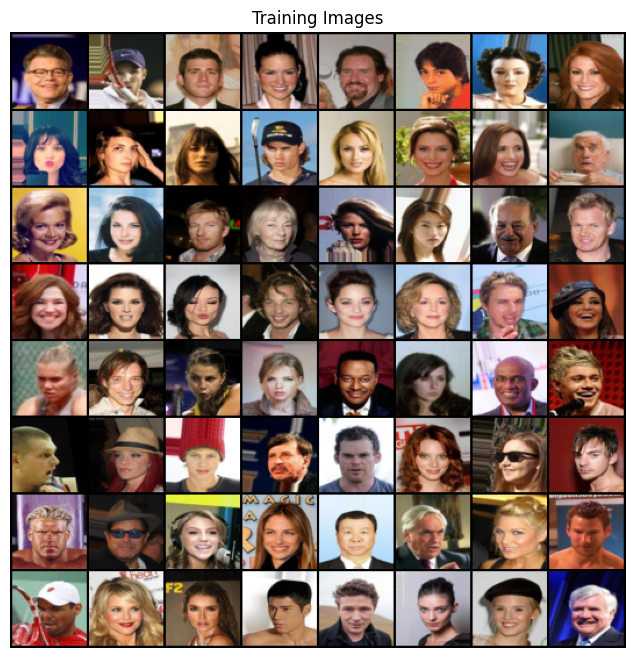

In [8]:
# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
## Defining an Encoder
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        #Input szie: 3 x 64 x 64 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1) # Output: 64 x 32 x 32
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # Output: 128 x 16 x 16
        self.batch2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0) # Output: 256 x 7 x 7
        self.batch3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=0) # Output: 256 x 3 x 3
        self.linear1 = nn.Linear(3*3*512, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()  # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
       

In [10]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3*3*512),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(512, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [11]:
# Merging the encoder and decoder
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [12]:
# Initializing the VAE
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3  # Learning rate

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

vae.to(device)   # Running the model on the GPU

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=4608, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=4608, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten

In [13]:
# Defining the function to train the VAE

def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [14]:
## Defining the function to test the VAE

def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [16]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_dataloader)
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

RuntimeError: stack expects each tensor to be equal size, but got [256, 3, 64, 64] at entry 0 and [256] at entry 1

In [ ]:
imshow(test_dataloader)

In [25]:
# Visualizing the training

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

In [26]:
num_epochs = 1

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_dataloader,optim)
   val_loss = test_epoch(vae,device,val_dataloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

	 partial train loss (single batch): 897245.187500
	 partial train loss (single batch): 903589.437500
	 partial train loss (single batch): 884069.125000
	 partial train loss (single batch): 878260.187500
	 partial train loss (single batch): 952059.125000
	 partial train loss (single batch): 869792.687500
	 partial train loss (single batch): 879566.625000
	 partial train loss (single batch): 868888.875000
	 partial train loss (single batch): 839898.250000
	 partial train loss (single batch): 843544.000000
	 partial train loss (single batch): 908951.875000
	 partial train loss (single batch): 894428.000000
	 partial train loss (single batch): 914353.125000
	 partial train loss (single batch): 873245.500000
	 partial train loss (single batch): 854428.062500
	 partial train loss (single batch): 907842.687500
	 partial train loss (single batch): 870289.312500
	 partial train loss (single batch): 808531.062500
	 partial train loss (single batch): 875251.687500
	 partial train loss (single ba

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1600x450 with 0 Axes>